In [114]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import project3
from scipy import stats
from scipy.optimize import minimize
import statsmodels.api as sm
sns.set_theme()

# Problem 1

Calculate and compare the expected value and standard deviation of price at time t ($P_t$). Given each of the 3 types of price returns, assuming $r_t\sim N(0,\sigma^2)$. Simulate each return equation using $r_t\sim N(0,\sigma^2)$ and show the mean and standard deviation match your expectations.

In [115]:
class simulate_price:
    '''Simulate the Price at date t given condition of price at date t-1 or t-time_periods'''
    def __init__(self,init_p,path_num=2000,time_periods=1):
        # initial price
        self.__init_p=init_p
        # random number generator from numpy
        self.__rng=np.random.default_rng()
        # Assume we only know the price of time T-time_periods
        self.__time_periods=time_periods
        # How much path/times of Monte Carlo simulations we will do
        self.__path_num=path_num

    def ClassicalBrownianMotion(self,mu=0,std=1):
        '''P_t=P_{t-1}+r_t'''
        # random normal returns
        random_returns=self.__rng.normal(mu,std,size=[self.__time_periods,self.__path_num])
        zeros=np.zeros([1,self.__path_num]) # keep initial price
        random_returns=np.r_[zeros,random_returns]
        random_returns=pd.DataFrame(random_returns)
        # price sample
        Price=self.__init_p + random_returns.cumsum()
        return Price
        

    def ArithmeticReturn(self,mu=0,std=1):
        '''P_t=P_{t-1}*(1+r_t)'''
        # random normal returns
        random_returns=self.__rng.normal(mu,std,size=[self.__time_periods,self.__path_num])
        zeros=np.zeros([1,self.__path_num]) # keep initial price
        random_returns=np.r_[zeros,random_returns]
        random_returns=pd.DataFrame(random_returns)
        # price sample
        Price=self.__init_p * (1+random_returns).cumprod()
        return Price
    
    def LogReturn(self,mu=0,std=1):
        '''Geometric Brownian Motion:
            P_t=P_{t-1}e^{r_t}
        '''
        # random normal returns
        random_returns=self.__rng.normal(mu,std,size=[self.__time_periods,self.__path_num])
        zeros=np.zeros([1,self.__path_num]) # keep initial price
        random_returns=np.r_[zeros,random_returns]
        random_returns=pd.DataFrame(random_returns)
        # price sample
        Price=self.__init_p * np.exp(random_returns.cumsum())
        return Price

    def expected_mean_var(self,mu=0,std=1):
        '''Calculate the expected Mean and Variance()'''

        ans=pd.DataFrame(columns=['Classical Brownian Motion', 'Arithmetic Return', 'Log Return (Geometric Brownian Motion)'],index=['Expected Mean','Expected Standard Deviation'])
        t=self.__time_periods #  time_periods
        p=self.__init_p # initial price
        mu=t*mu # adjusted mu
        std=np.sqrt(t)*std # adjusted std
        var=std**2 
        mean_arith_rt=p*(1+mu) if t==1 else np.nan # mean of Arithmetic Return
        std_arith_rt=p*std if t==1 else np.nan # std of Arithmetic Return
        ans.loc['Expected Mean']=[p+mu,mean_arith_rt,p*np.exp(var/2)]
        ans.loc['Expected Standard Deviation']=[std,std_arith_rt,p*np.sqrt(np.exp(var)*(np.exp(var)-1))]
        return ans
    
    def comparison(self,mu=0,std=1):
        Price=pd.DataFrame(columns=['Classical Brownian Motion', 'Arithmetic Return', 'Log Return (Geometric Brownian Motion)'])
        
        # Get all the price
        Classical_BM=self.ClassicalBrownianMotion(mu=mu,std=std)
        Arithmetic_r=self.ArithmeticReturn(mu=mu,std=std)
        Log_r=self.LogReturn(mu=mu,std=std)
        
        # Get end date price
        Price.iloc[:,0]=Classical_BM.iloc[-1,:]
        Price.iloc[:,1]=Arithmetic_r.iloc[-1,:]
        Price.iloc[:,2]=Log_r.iloc[-1,:]
        
        # Calculate expected Mean & Variance
        expected=self.expected_mean_var(mu,std)

        # Mean & Standard Deviation
        df=pd.DataFrame(columns=['Classical Brownian Motion', 'Arithmetic Return', 'Log Return (Geometric Brownian Motion)'],index=['Mean','Expected Mean','Standard Deviation','Expected Standard Deviation'])
        df.loc['Mean']=Price.mean()
        df.loc['Standard Deviation']=Price.std()
        df.loc['Expected Mean']=expected.loc['Expected Mean']
        df.loc['Expected Standard Deviation']=expected.loc['Expected Standard Deviation']
        print(df)

        # Plot
        fig, ax = plt.subplots(3,2,figsize=(14,20))
        Classical_BM.plot(ax=ax[0][0],legend=False,xlabel='Time',ylabel='Price',title="Classical Brownian Motion({} path)".format(self.__path_num))
        Arithmetic_r.plot(ax=ax[1][0],legend=False,xlabel='Time',ylabel='Price',title="Arithmetic Return({} path)".format(self.__path_num))
        Log_r.plot(ax=ax[2][0],legend=False,xlabel='Time',ylabel='Price',title="Log Return (Geometric Brownian Motion)({} path)".format(self.__path_num))

        sns.histplot(data=Price['Classical Brownian Motion'],kde=True,stat="density",ax=ax[0][1])
        sns.histplot(data=Price['Arithmetic Return'],stat="density",kde=True,ax=ax[1][1])
        sns.histplot(data=Price['Log Return (Geometric Brownian Motion)'],stat="density",kde=True,ax=ax[2][1])
        ax[0][1].set_title("End Date Price Distribution")
        ax[1][1].set_title("End Date Price Distribution")
        ax[2][1].set_title("End Date Price Distribution")

        # Save file
        writer = pd.ExcelWriter('Validation.xlsx')  #Build excel file
        # Use float_format to control precision; write data_df to the last page of file. If we have mutiple file, we could write sequentially.
        df.to_excel(writer,'page_1',float_format='%.5f') 
        writer.save()  # save file


                            Classical Brownian Motion Arithmetic Return  \
Mean                                         1.006125          0.985464   
Expected Mean                                       1                 1   
Standard Deviation                           0.510321          0.505252   
Expected Standard Deviation                       0.5               0.5   

                            Log Return (Geometric Brownian Motion)  
Mean                                                      1.129208  
Expected Mean                                             1.133148  
Standard Deviation                                        0.596851  
Expected Standard Deviation                               0.603901  


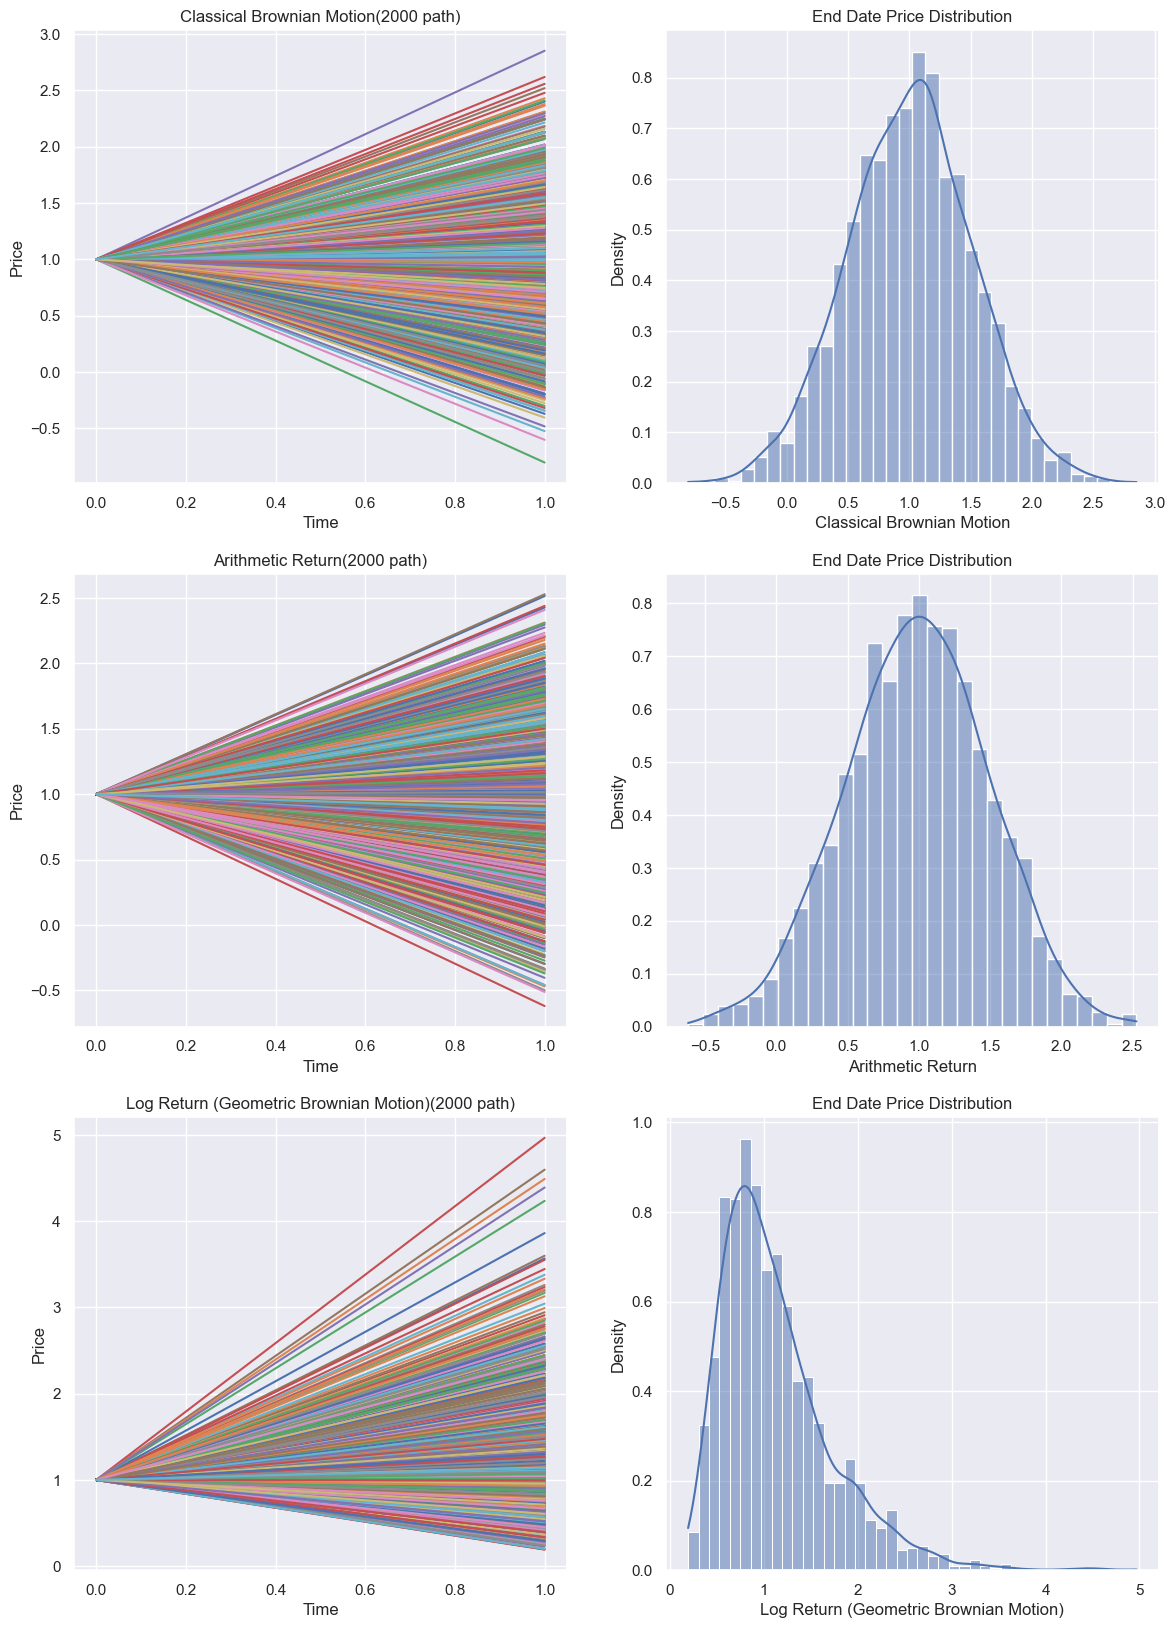

In [116]:
simulate_price(1,path_num=2000,time_periods=1).comparison(std=0.5)

                            Classical Brownian Motion Arithmetic Return  \
Mean                                         0.997379          0.983229   
Expected Mean                                       1               NaN   
Standard Deviation                           0.494898          0.517542   
Expected Standard Deviation                       0.5               NaN   

                            Log Return (Geometric Brownian Motion)  
Mean                                                       1.14648  
Expected Mean                                             1.133148  
Standard Deviation                                        0.597558  
Expected Standard Deviation                               0.603901  


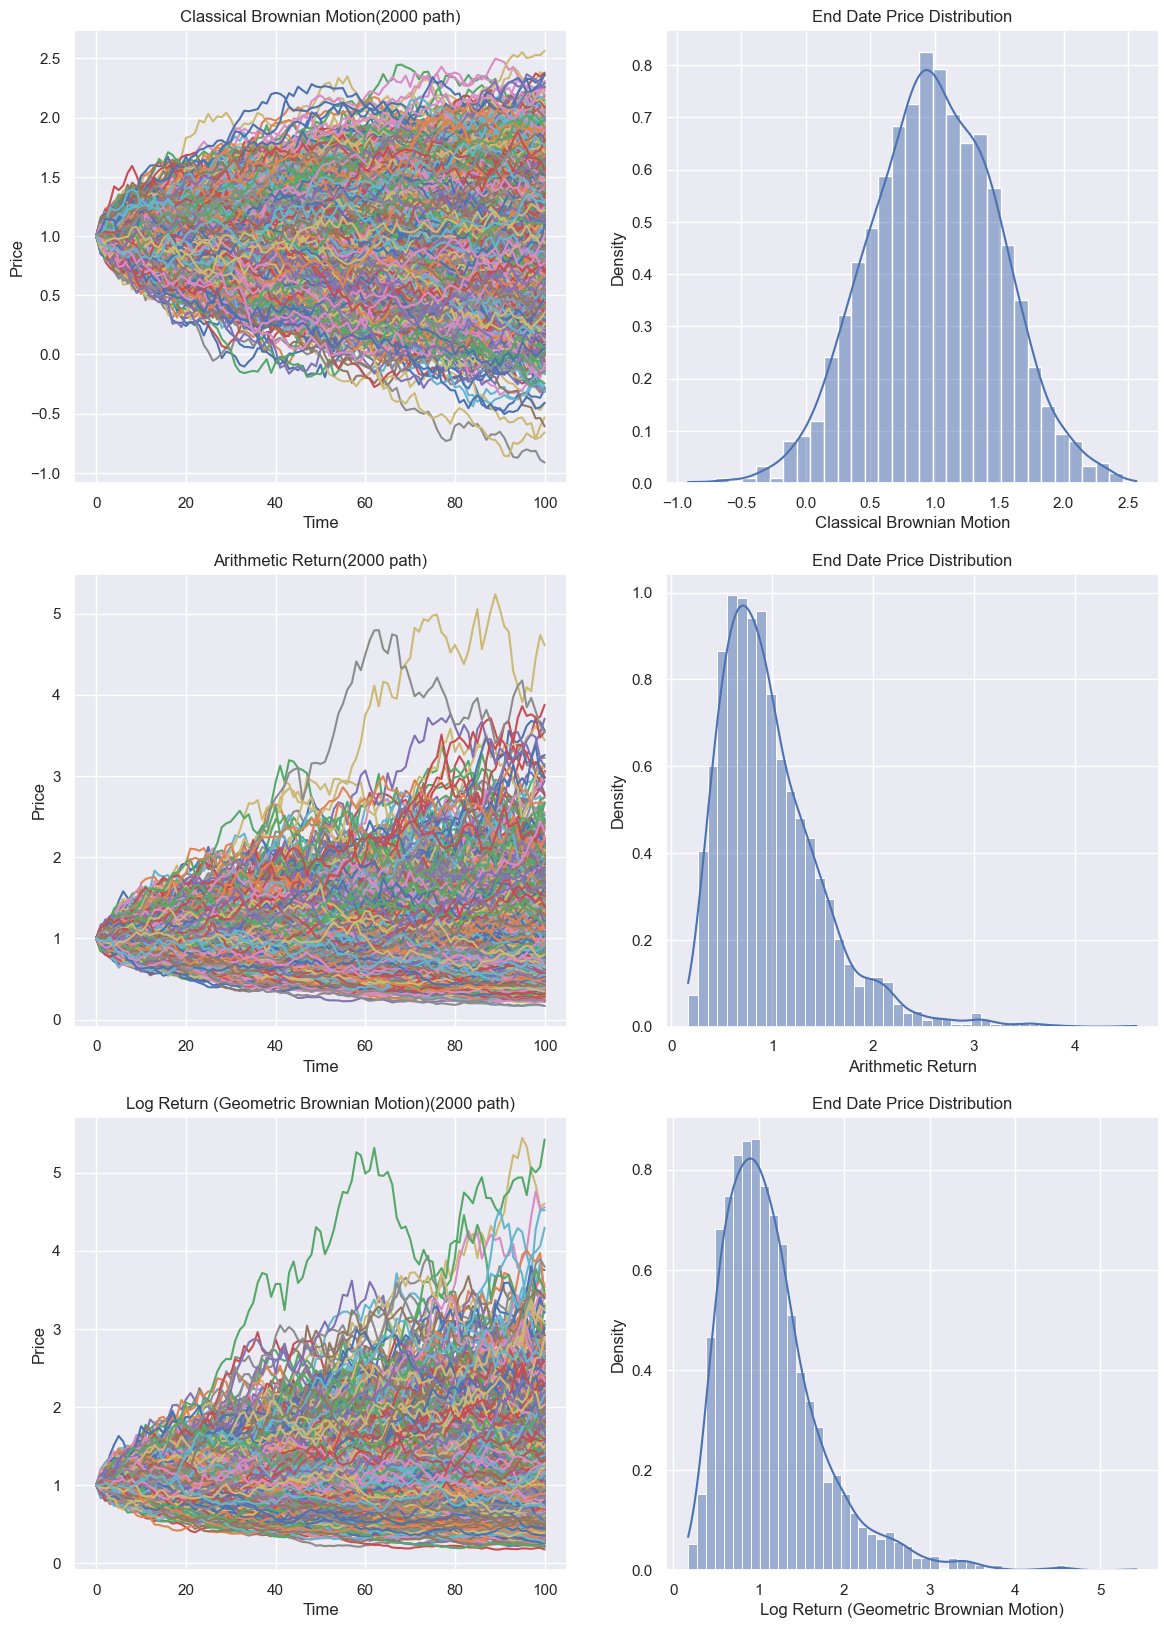

In [117]:
simulate_price(1,path_num=2000,time_periods=100).comparison(std=0.05)

# Problem 2

Implement a function similar to the “return_calculate()” in this week’s code. Allow the user to specify the method of return calculation.

Use DailyPrices.csv. Calculate the arithmetic returns for all prices.

Remove the mean from the series so that the mean(META)=0.

Calculate VaR:
1. Using a normal distribution.
2. Using a normal distribution with an Exponentially Weighted variance $\lambda$ = 0. 94
3. Using a MLE fitted T distribution.
4. Using a fitted AR(1) model.
5. Using a Historic Simulation.

Compare the 5 values.

In [118]:
def return_calculate(Price,option="DISCRETE",rm_means=True):
    '''
        Provide two ways to calculate the return from Price dataframce.
    '''
    # calculate the log normal return 
    if option == 'CONTINUOUS':
        returns = np.log(df/df.shift()).dropna()
    # calculate the discrete return 
    elif  option == 'DISCRETE':
        returns = df.pct_change().dropna()
    # other undefined option will cause error
    else:
        raise Exception("Unknown Option!")
    # remove mean from the returns
    return returns if rm_means==False else returns-returns.mean()
    

In [119]:
class T_fitter:
    '''T distribution MEL fitter'''
    def ll_t(self,parameter,x):
        # log likelihood 
        ll=np.sum(stats.t.logpdf(x=x,df=parameter[0],loc=0,scale=parameter[1])) # assume mean to be 0
        return -ll

    def MLE(self,x):
        cons=[ {'type':'ineq', 'fun':lambda x:x[1]} ] # standard deviation is non-negative
        parameter = np.array([x.size-1,1])
        MLE = minimize(self.ll_t, parameter, args = x, constraints = cons) # MLE
        return MLE.x

In [120]:
def simulate_AR1_process(alpha,beta,sigma,sample_size):
    # Simulate AR(1) process
    ''' AR(1)
        y_t = alpha + beta*y_t-1 + e, e ~ N(0,sigma2)
    '''
    x0=alpha/(1-beta)
    x=np.zeros(sample_size+1)
    x[0]=x0
    eps=stats.norm.rvs(size=sample_size,scale=sigma)
    for i in range(sample_size):
        x[i+1]=alpha+beta*x[i]+eps[i]
    return x

In [141]:
class VaR:
    '''Calculate the VaR of 1D array or dataframe of return due to specific distribution'''
    def __init__(self,data,option="Absolute",alpha=0.05):
        # Absolute Value at risk or Relative Value at risk
        if option != "Absolute" and option != "Relative":
            raise Exception('Unknown option!')
        self.__option=option
        # 1-alpha is confidence level
        self.__alpha=alpha
        # returns data (DataFrame)
        self.__data=data

    def normal(self,option='Normal',plot=False):
        '''Assume returns follow normal distribution'''
        # assume mean to be 0
        mu=0
        # calculate the standard deviation
        if option == 'Normal': # use normal standard deviation
            std=self.__data.std() 
        elif option == 'EWMA': # use EW standard deviation
            model=project3.EWMA(META,0.94) # assume lambda = 0.94
            std=np.sqrt(model.cov_mat)
        else: 
            raise Exception('Unknown option!')
         # calculate the VaR
        if self.__option=="Absolute":
            VaR=-stats.norm.ppf(self.__alpha,loc=mu,scale=std)
        else:
            VaR=self.__data.mean()-stats.norm.ppf(self.__alpha,loc=mu,scale=std)

        if plot:
            # plot the normal Probability density function
            max_val=self.__data.max()
            min_val=self.__data.min()
            x=np.linspace(min_val,max_val,1000)
            y=stats.norm.pdf(x=x,loc=mu,scale=std)
            plt.plot(x,y,color='brown')
            # fill VaR area
            plt.fill_between(x,y,where=x<-VaR,color="red", alpha=0.3)
            # plot the return data & its empirical kde
            sns.histplot(self.__data,kde=True,stat='density')
            # plot the VaR
            plt.axvline(-VaR,color='#FF6347')
            if option == 'Normal':
                plt.title("Normal")
                plt.legend(['Normal','VaR','historical'])
            else:
                plt.title("Normal with EW standard deviation")
                plt.legend(['Normal','VaR','historical'])
        return VaR
        
    def T_dist(self,plot=False):
        para=T_fitter().MLE(self.__data)
        mu=0 # assume mean to be 0
        df=para[0] # degree of freedom of T distribution
        std=para[1] # standard deviation
        # calculate the VaR
        if self.__option=="Absolute":
            VaR=-stats.t.ppf(self.__alpha,df=df,loc=mu,scale=std)
        else:
            VaR=self.__data.mean()-stats.t.ppf(self.__alpha,df=df,loc=mu,scale=std)
        if plot:
            # plot the T Probability density function
            max_val=self.__data.max()
            min_val=self.__data.min()
            x=np.linspace(min_val,max_val,1000)
            y=stats.t.pdf(x=x,df=df,loc=mu,scale=std)
            plt.plot(x,y,color='brown')
            # fill VaR area
            plt.fill_between(x,y,where=x<-VaR,color="red", alpha=0.3)
            # plot the return data & its empirical kde
            sns.histplot(self.__data,kde=True,stat='density')
            # plot the VaR
            plt.axvline(-VaR,color='#FF6347')
            plt.title("MLE fitted T distribution")
            plt.legend(['T distribution','VaR','historical'])
        return VaR

    def AR_1(self,plot=False):
        # Use AR(1) fitter to find the best cofficience
        mod = sm.tsa.arima.ARIMA(META.values, order=(1, 0, 0))
        res = mod.fit()
        const=0 # constant number
        ar_L1=res.params[1] # cofficience of Lag 1
        sigma2=res.params[2] # variance of error term

        # AR(1) is also normal
        mu=0
        std=np.sqrt(sigma2/(1-ar_L1))

        # calculate the VaR
        if self.__option=="Absolute":
            VaR=-stats.norm.ppf(self.__alpha,loc=mu,scale=std)
        else:
            VaR=self.__data.mean()-stats.norm.ppf(self.__alpha,loc=mu,scale=std)
        
        if plot:
            # plot the AR(1) Probability density function
            max_val=self.__data.max()
            min_val=self.__data.min()
            x=np.linspace(min_val,max_val,1000)
            y=stats.norm.pdf(x=x,loc=mu,scale=std)
            plt.plot(x,y,color='brown')
            # fill VaR area
            plt.fill_between(x,y,where=x<-VaR,color="red", alpha=0.3)
            # plot the return data & its empirical kde
            sns.histplot(self.__data,kde=True,stat='density')
            # plot the VaR
            plt.axvline(-VaR,color='#FF6347')
            plt.title("fitted AR(1)")
            plt.legend(['fitted AR(1)','VaR','historical'])
        return VaR
    
    def historical_simulation(self,alpha,plot=False):
        size=self.__data.shape[0]
        rt=self.__data.sample(n=size,replace=True)
        # calculate the VaR
        if self.__option=="Absolute":
            VaR=-np.quantile(rt,alpha)
        else:
            VaR=rt.mean()-np.quantile(rt,alpha)
        if plot:
            # plot the historical kde
            sns.kdeplot(rt,color='brown')

            # plot the return data & its empirical kde
            ax = sns.histplot(self.__data,kde=True,stat='density')
            
            # fill VaR area
            # Get the two lines from the axes to generate shading
            l = ax.lines[0]
            # Get the xy data from the lines so that we can shade
            x = l.get_xydata()[:,0]
            y = l.get_xydata()[:,1]
            ax.fill_between(x,y,where=x<-VaR,color="red", alpha=0.3)

            # plot the VaR
            plt.axvline(-VaR,color='#FF6347')
            plt.title("historical simulation")
            plt.legend(['historical simulation','VaR','historical'])
        return VaR
        

In [142]:
# parse the DailyPrices data into dataframe
df=pd.read_csv('DailyPrices.csv',index_col='Date')
# calculate the returns
rt=return_calculate(df)
META=rt['META']

In [143]:
# calculate VaR via 5 methods
VaR_normal=VaR(META).normal()
VaR_normal_EWMA=VaR(META).normal('EWMA')
VaR_T=VaR(META).T_dist()
VaR_AR_1=VaR(META).AR_1()
VaR_normal_historical=VaR(META).historical_simulation(0.05)
print("VaR (Normal Distribution): {}".format(VaR_normal))
print("VaR (Normal Distribution + EWMA): {}".format(VaR_normal_EWMA))
print("VaR (MLE Fitted T Distribution): {}".format(VaR_T))
print("VaR (AR(1) Process): {}".format(VaR_AR_1))
print("VaR (Historical sampling): {}".format(VaR_normal_historical))

VaR (Normal Distribution): 0.06560156967533284
VaR (Normal Distribution + EWMA): 0.09138525104032248
VaR (MLE Fitted T Distribution): 0.05725632756853766
VaR (AR(1) Process): 0.06570519171558095
VaR (Historical sampling): 0.06160425083130407


/Users/qijunyang/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2126: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


VaR (Normal Distribution): 0.06560156967533284


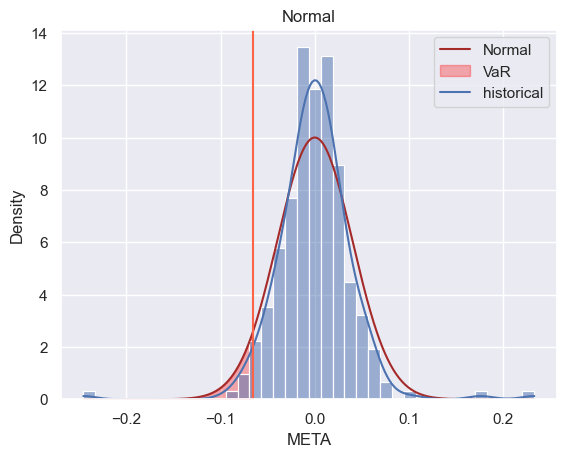

In [144]:
# Using a normal distribution
VaR_normal=VaR(META).normal(plot=True)
print("VaR (Normal Distribution): {}".format(VaR_normal))

VaR (Normal Distribution + EWMA): 0.09138525104032248


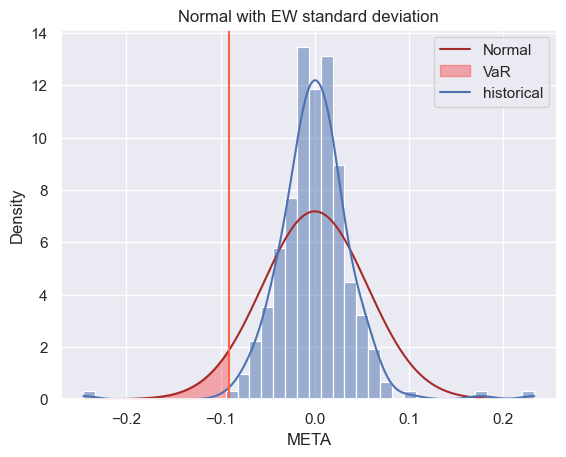

In [145]:
# Using a normal distribution with an Exponentially Weighted variance 
VaR_normal_EWMA=VaR(META).normal('EWMA',plot=True)
print("VaR (Normal Distribution + EWMA): {}".format(VaR_normal_EWMA))

VaR (MLE Fitted T Distribution): 0.05725632756853766


/Users/qijunyang/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2126: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


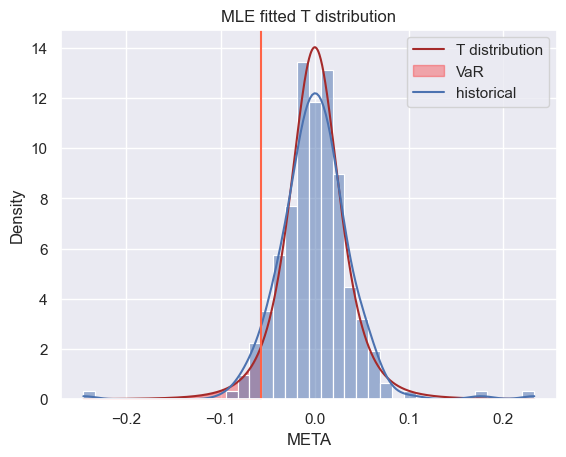

In [146]:
# Using a MLE fitted T distribution
VaR_T=VaR(META).T_dist(plot=True)
print("VaR (MLE Fitted T Distribution): {}".format(VaR_T))

VaR (AR(1) Process): 0.06570519171558095


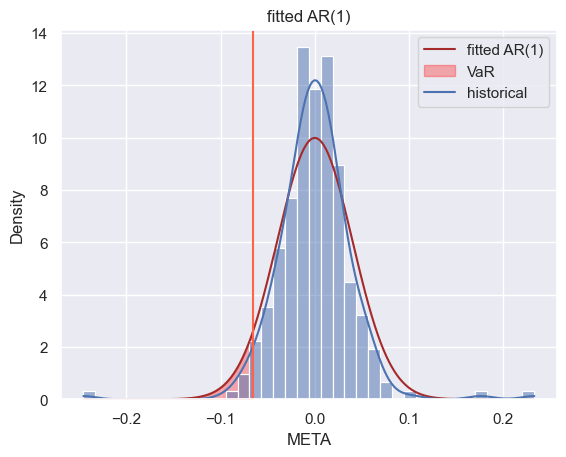

In [147]:
# Using a fitted AR(1) model.
VaR_AR_1=VaR(META).AR_1(plot=True)
print("VaR (AR(1) Process): {}".format(VaR_AR_1))

VaR (Historical sampling): 0.06655026296316648


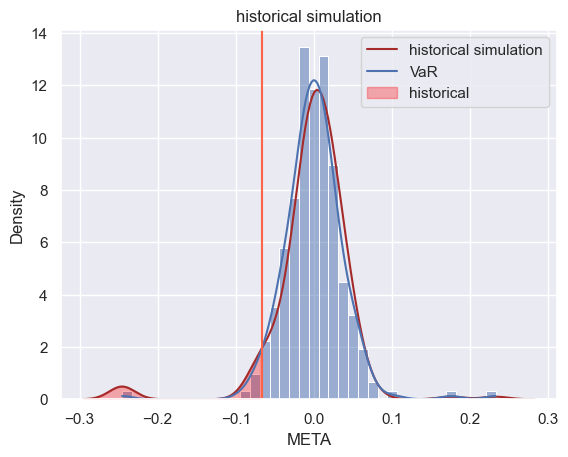

In [148]:
# Using a Historic Simulation.
VaR_normal_historical=VaR(META).historical_simulation(0.05,plot=True)
print("VaR (Historical sampling): {}".format(VaR_normal_historical))

# Problem 3

Using Portfolio.csv and DailyPrices.csv. Assume the expected return on all stocks is 0.

This file contains the stock holdings of 3 portfolios. You own each of these portfolios. Using an
exponentially weighted covariance with lambda = 0.94, calculate the VaR of each portfolio as
well as your total VaR (VaR of the total holdings). Express VaR as a $

Discuss your methods and your results.

Choose a different model for returns and calculate VaR again. Why did you choose that model? How did the model change affect the results?

In [129]:
# parse the DailyPrices data into dataframe
price=pd.read_csv('DailyPrices.csv',index_col='Date')
# calculate the returns
rt=return_calculate(price)
# information about portfolio
portfolio=pd.read_csv('portfolio.csv',index_col='Portfolio')

In [130]:
class VaR_portfolio:
    '''Differnet Method to get the VaR of stock portfolio'''
    # initialization
    def __init__(self,portfolio,returns,price):
        '''The fromat of data should be same as the file in the current directory.'''
        # information about portfolio
        self.__portfolio=portfolio
        # returns information about companies
        self.__returns=returns
        # price about stock
        self.__price=price

    def delta_normal(self,alpha=0.05,option='EWMA'):
        ''' Delta Normal method to calculate the VaR of the Stock portfolio
            
            Parmeter:
                option='EWMA' or 'std'
        '''
        stocks = self.__portfolio.Stock.values # stocks of portfilio
        rt=self.__returns[stocks] # return of each stock of the portfilio
        portfolio=self.__portfolio.set_index('Stock') # set the portfolio index to be Stock
        holding=portfolio.loc[stocks].Holding # get holding of each stock of the portfilio
        current_price=self.__price[stocks].iloc[-1,:] # get current price of each stock of the portfilio
        current_position = holding * current_price # current position of each stock of the portfilio
        PV = current_position.sum() # portfolio value
        delta=current_position/PV # calculate the delta
        stocks = self.__portfolio.Stock.values
        rt=self.__returns[stocks]

        if option=='EWMA':
            # Calculate EWMA covariance
            model=project3.EWMA(rt.values,0.94) # assume lambda = 0.94
            cov_mat=model.cov_mat
        elif option=='std':
            # Calculate standard deviation
            cov_mat=rt.cov()

        # calculate the std of portfolio
        std = np.sqrt(delta @ cov_mat @ delta)
        # get the VaR of the portfolio
        VaR_p = PV*(-stats.norm.ppf(alpha))*std
        return VaR_p

    def normal_MC(self,alpha=0.05,option='EWMA',method='PCA',draw_num=100000,pct=1,plot=False,VaROption='Absolute',p_name=''):
        ''' Use Monte Carlo Methods to simulate the price of each stock of portfolio
            then calculate the value of the portfolio
            
            Parmeter:
                option: 'EWMA' or 'std'
                method: 'PCA' or 'Cholesky'
                VaROption: 'Absolute' VaR or 'Relative' VaR
                draw_num: number of path simulated
                pct: the percentage of variance expained by PCA
                plot: plot the simulated path or not
                alpha: 1-alpha is confidence level
                p_name: portfolio name
        '''
        stocks = self.__portfolio.Stock.values # stocks of portfilio
        rt=self.__returns[stocks] # return of each stock of the portfilio
        portfolio=self.__portfolio.set_index('Stock') # set the portfolio index to be Stock
        holding=portfolio.loc[stocks].Holding # get holding of each stock of the portfilio
        current_price=self.__price[stocks].iloc[-1,:] # get current price of each stock of the portfilio

        # get the covariance
        if option=='EWMA':
            # Calculate EWMA covariance
            model=project3.EWMA(rt.values,0.94) # assume lambda = 0.94
            cov_mat=model.cov_mat
        elif option=='std':
            # Calculate standard deviation
            cov_mat=rt.cov()
        else:
            raise Exception("Unknown option!")
        
        # MC to get the simulated return
        simulator = project3.Simulator(cov_mat,draw_num)
        if method=='PCA':
            simulated_rt=simulator.PCA_Simulation(pct)
        elif method=='Cholesky':
            simulated_rt=simulator.DirectSimulation()
        else:
            raise Exception("Unknown method!")
        # simulated price
        simulate_price = np.expand_dims(current_price,1).repeat(draw_num,axis=1) * simulated_rt
        # simulated position
        simulate_position=np.expand_dims(holding,1).repeat(draw_num,axis=1) * simulate_price
        # simulated portfolio value
        simulate_PV=pd.DataFrame(simulate_position).sum()
        # sort
        simulate_PV=pd.DataFrame(simulate_PV.sort_values(ascending=True))
    
        if VaROption=="Absolute":
            VaR_p=-np.quantile(simulate_PV,alpha)
        elif VaROption=='Relative':
            VaR_p=simulate_PV.mean()-np.quantile(simulate_PV,alpha)
        else:
            raise Exception("Unknown VaROption!")
        
        
        if plot:
            # add current Portfolio value
            simulate_PV[1]=simulate_PV
            simulate_PV[0]=0
            plot_data=simulate_PV.T
            # plot
            fig, ax = plt.subplots(1,2,figsize=(14,6))
            plot_data.plot(ax=ax[0],legend=False,xlabel='Time',ylabel='Price',title="Mote Carlo Simulation({} path) for portfolio {}".format(draw_num,p_name))
            sns.histplot(data=simulate_PV[1],kde=True,stat="density",ax=ax[1])

            # fill VaR area
            # Get the two lines from the axes to generate shading
            l = ax[1].lines[0]
            # Get the xy data from the lines so that we can shade
            x = l.get_xydata()[:,0]
            y = l.get_xydata()[:,1]
            ax[1].fill_between(x,y,where=x<-VaR_p,color="red", alpha=0.3)
            
            # plot the VaR
            plt.axvline(-VaR_p,color='#FF6347')
            plt.title("Monte Carlo Simulated VaR($) of Portfolio {}".format(p_name))
            plt.legend(['MC simulation kde','VaR'])
        return VaR_p




    def historical_simulation(self,alpha=0.05,draw_num=10000,plot=False,p_name='',VaROption='Absolute'):
        ''' Use historical returns as dataset, draw sample from it to simulate the 
            potential loss (VaR)

            Parameter:
                draw_num: number of path simulated
                p_name: portfolio name
                VaROption: 'Absolute' VaR or 'Relative' VaR
        '''
        stocks = self.__portfolio.Stock.values # stocks of portfilio
        rt=self.__returns[stocks] # return of each stock of the portfilio
        portfolio=self.__portfolio.set_index('Stock') # set the portfolio index to be Stock
        holding=portfolio.loc[stocks].Holding # get holding of each stock of the portfilio
        current_price=self.__price[stocks].iloc[-1,:] # get current price of each stock of the portfilio

        # sampling from the historical returns
        size=draw_num
        historical_rt=rt.sample(n=size,replace=True)

        # simulated price
        simulate_price = np.expand_dims(current_price,1).repeat(draw_num,axis=1) * (historical_rt.T)
        # simulated position
        simulate_position=np.expand_dims(holding,1).repeat(draw_num,axis=1) * simulate_price
        # simulated portfolio value
        simulate_PV=pd.DataFrame(simulate_position).sum()
        # sort
        simulate_PV=pd.DataFrame(simulate_PV.sort_values(ascending=True))
        
        if VaROption=="Absolute":
            VaR_p=-np.quantile(simulate_PV,alpha)
        elif VaROption=='Relative':
            VaR_p=simulate_PV.mean()-np.quantile(simulate_PV,alpha)
        else:
            raise Exception("Unknown VaROption!")

        if plot:
            # add a column of current Portfolio value
            simulate_PV[1]=simulate_PV
            simulate_PV[0]=0
            plot_data=simulate_PV.T
            # plot
            fig, ax = plt.subplots(1,2,figsize=(14,6))
            plot_data.plot(ax=ax[0],legend=False,xlabel='Time',ylabel='Price',title="Historical Simulation({} path) for portfolio {}".format(draw_num,p_name))
            sns.histplot(data=simulate_PV[1],kde=True,stat="density",ax=ax[1])

            # fill VaR area
            # Get the two lines from the axes to generate shading
            l = ax[1].lines[0]
            # Get the xy data from the lines so that we can shade
            x = l.get_xydata()[:,0]
            y = l.get_xydata()[:,1]
            ax[1].fill_between(x,y,where=x<-VaR_p,color="red", alpha=0.3)

            # plot the VaR
            plt.axvline( x=-VaR_p ,color='#FF6347')
            plt.title("Historical Simulated VaR($) of Portfolio {}".format(p_name))
            plt.legend(['Historical simulation kde','VaR'])

        return VaR_p
        


In [131]:
# Delta Normal + EWMA
A=VaR_portfolio(portfolio.loc['A'],rt,price).delta_normal(0.05)
print("VaR of portfolio A is {}".format(A))
B=VaR_portfolio(portfolio.loc['B'],rt,price).delta_normal(0.05)
print("VaR of portfolio B is {}".format(B))
C=VaR_portfolio(portfolio.loc['C'],rt,price).delta_normal(0.05)
print("VaR of portfolio C is {}".format(C))
All=VaR_portfolio(portfolio,rt,price).delta_normal(0.05)
print("VaR of the whole portfolio is {}".format(All))

VaR of portfolio A is 5670.202305994697
VaR of portfolio B is 4494.597923958032
VaR of portfolio C is 3786.5886006749397
VaR of the whole portfolio is 13577.073948413006


VaR of portfolio A is 5706.60952883074
VaR of portfolio B is 4456.928768528979
VaR of portfolio C is 3797.419732156959
VaR of the whole portfolio is 13570.228862335613


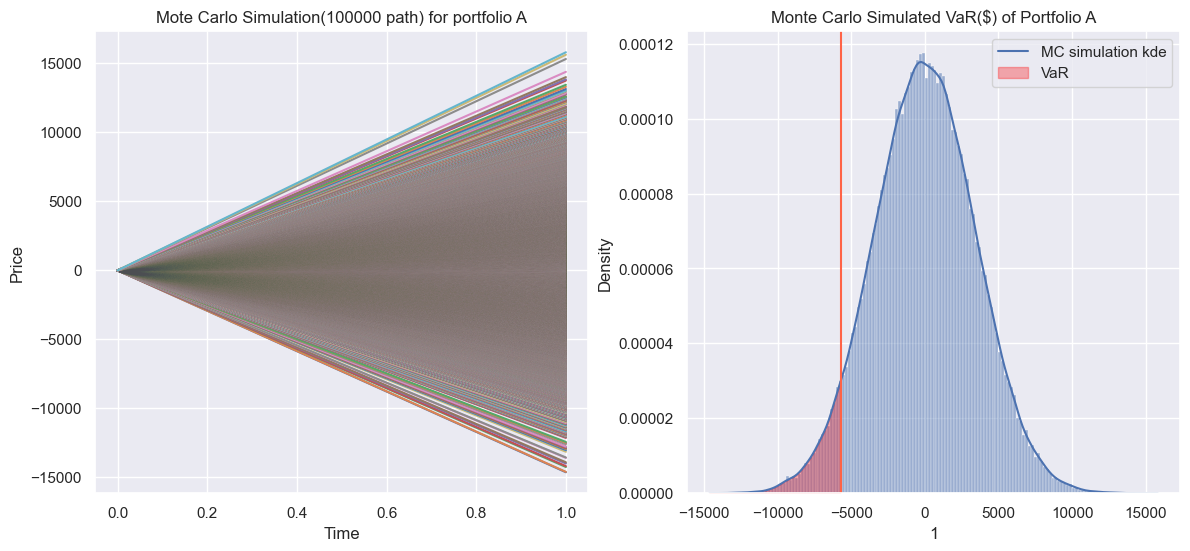

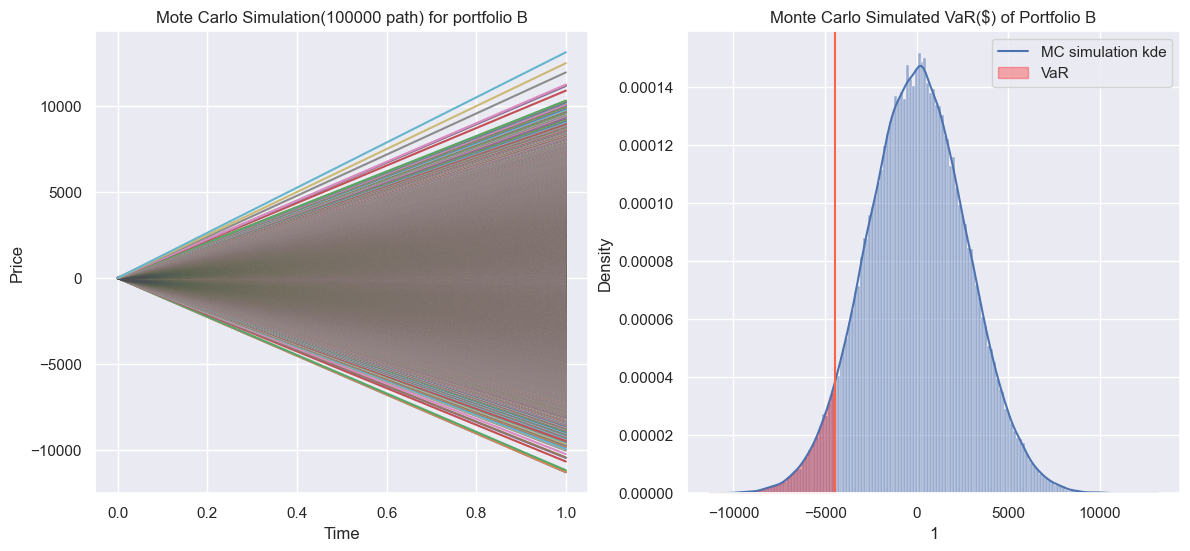

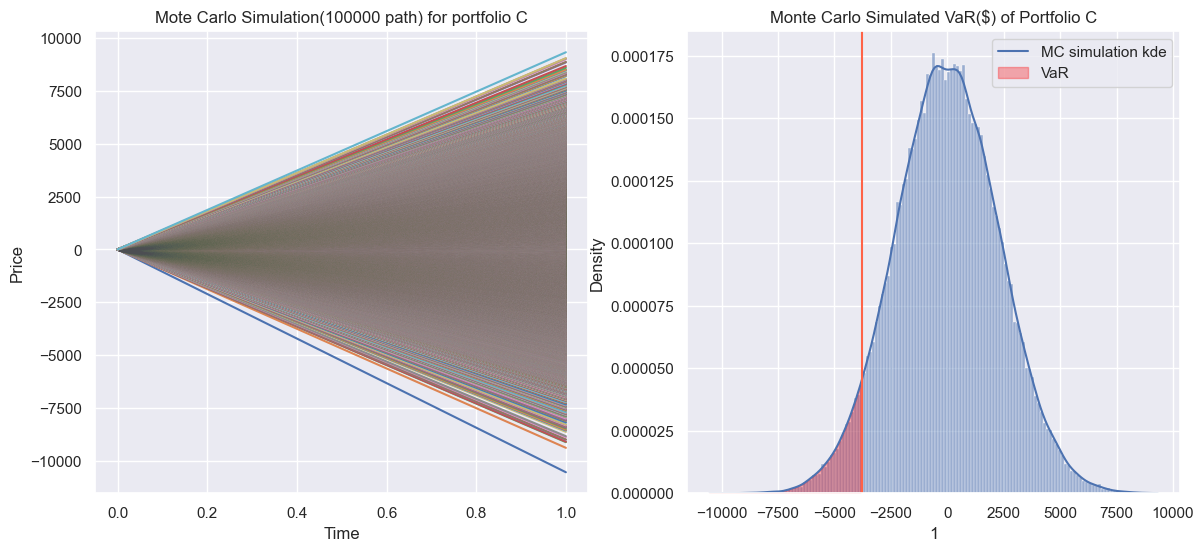

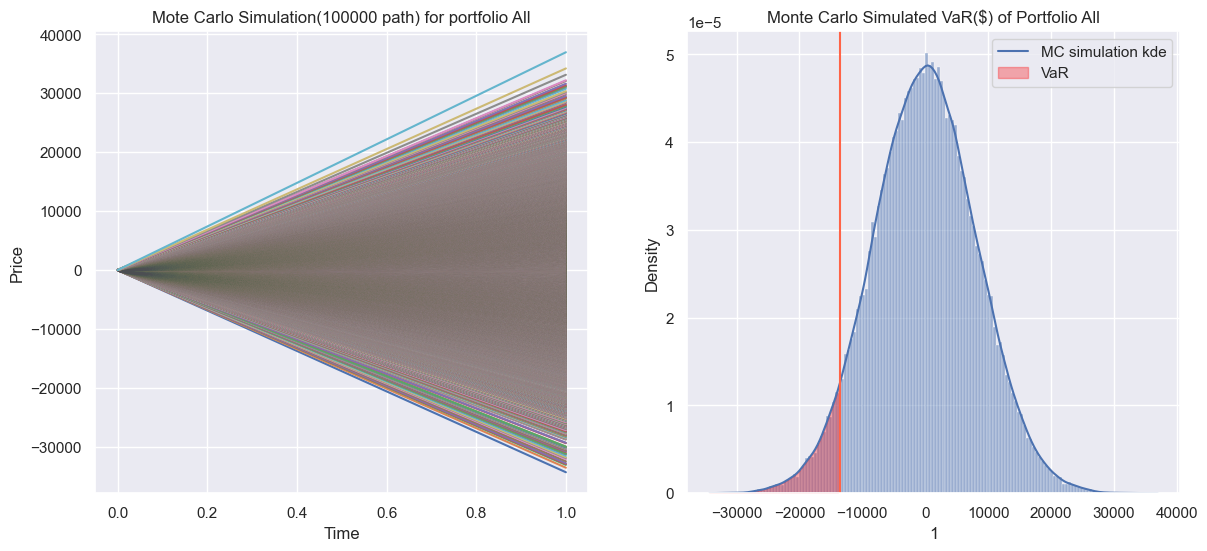

In [149]:
# Normal Monte Carlo Simulation 
A=VaR_portfolio(portfolio.loc['A'],rt,price).normal_MC(plot=True,p_name='A')
print("VaR of portfolio A is {}".format(A))
B=VaR_portfolio(portfolio.loc['B'],rt,price).normal_MC(plot=True,p_name='B')
print("VaR of portfolio B is {}".format(B))
C=VaR_portfolio(portfolio.loc['C'],rt,price).normal_MC(plot=True,p_name='C')
print("VaR of portfolio C is {}".format(C))
All=VaR_portfolio(portfolio,rt,price).normal_MC(plot=True,p_name='All')
print("VaR of the whole portfolio is {}".format(All))

VaR of portfolio A is 9070.104361894266
VaR of portfolio B is 7351.16647144181
VaR of portfolio C is 5802.652861113043
VaR of the whole portfolio is 21275.01310993595


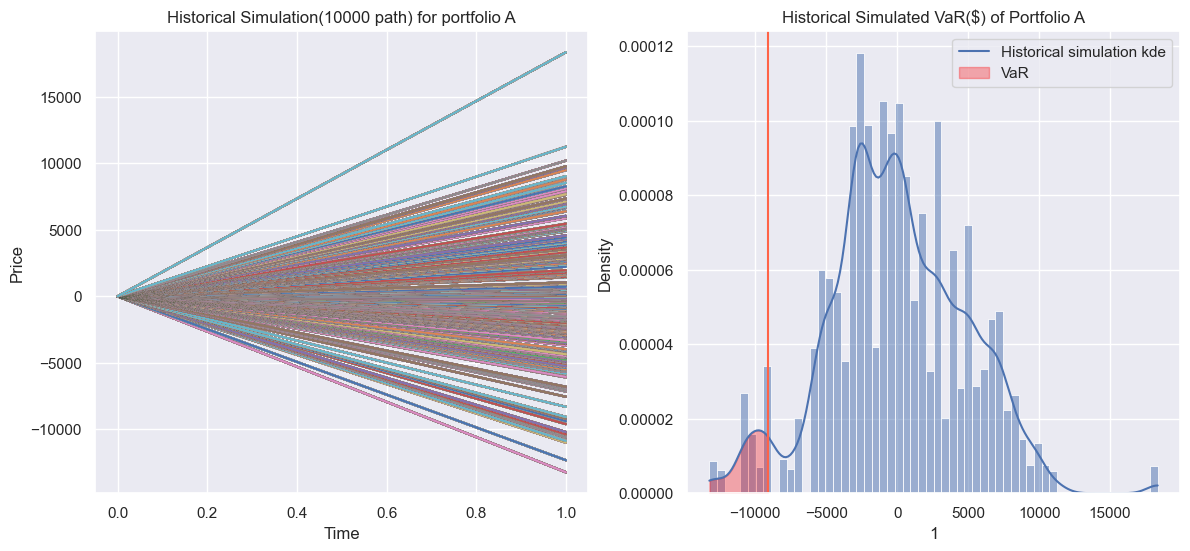

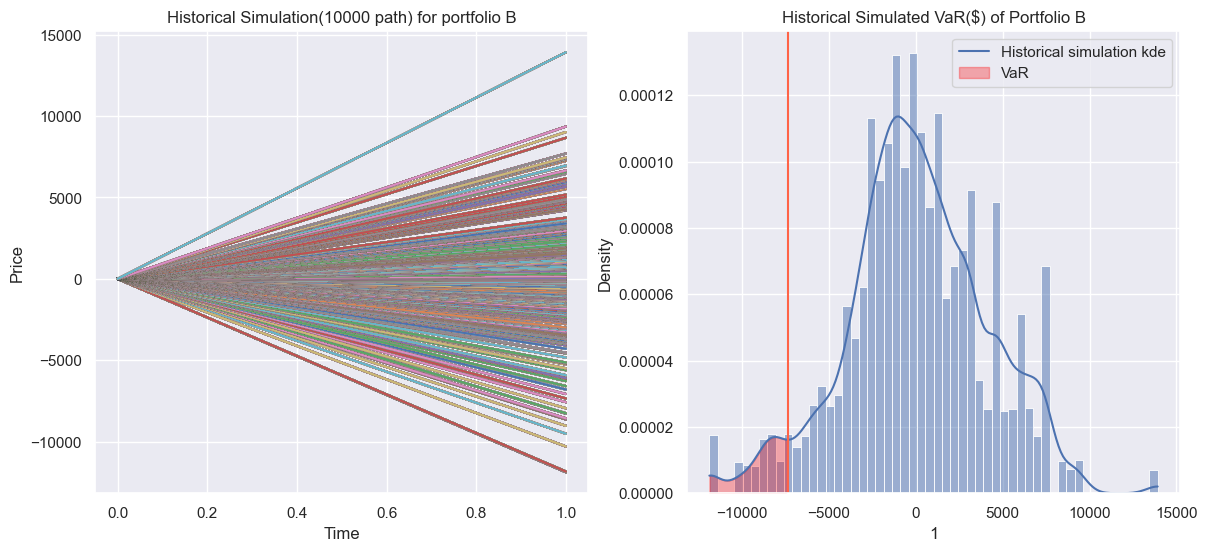

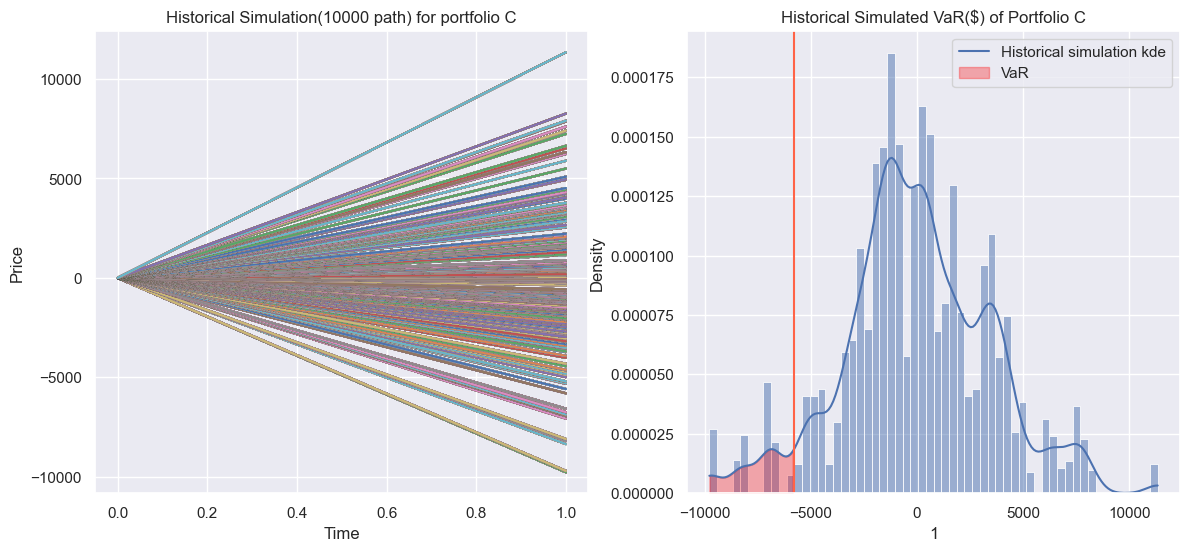

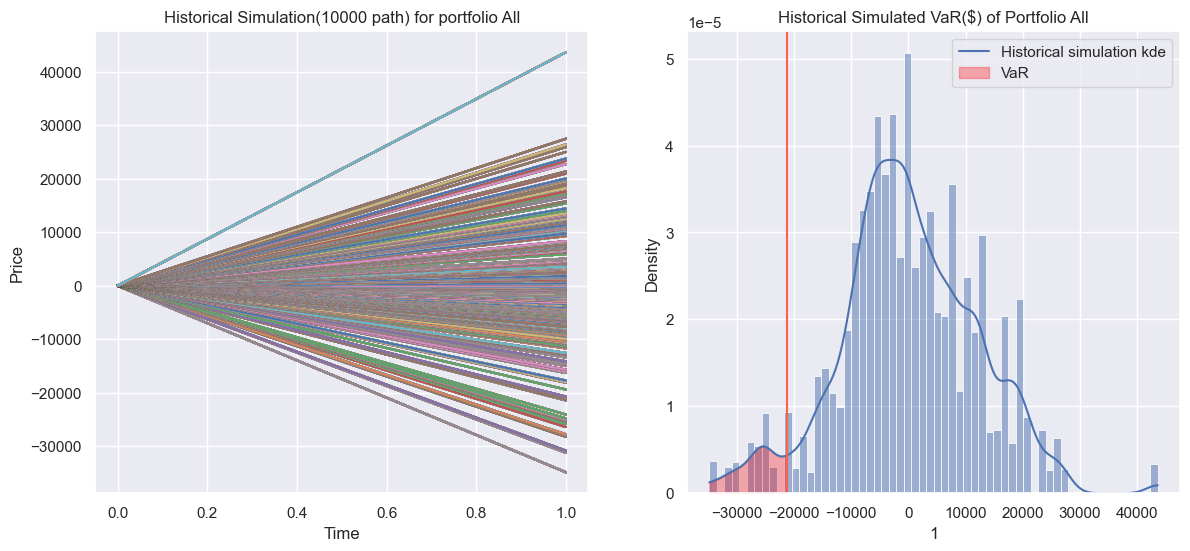

In [133]:
# Historical Simulation 
A=VaR_portfolio(portfolio.loc['A'],rt,price).historical_simulation(plot=True,p_name='A')
print("VaR of portfolio A is {}".format(A))
B=VaR_portfolio(portfolio.loc['B'],rt,price).historical_simulation(plot=True,p_name='B')
print("VaR of portfolio B is {}".format(B))
C=VaR_portfolio(portfolio.loc['C'],rt,price).historical_simulation(plot=True,p_name='C')
print("VaR of portfolio C is {}".format(C))
All=VaR_portfolio(portfolio,rt,price).historical_simulation(plot=True,p_name='All')
print("VaR of the whole portfolio is {}".format(All))